In [1]:
! pip install transformers==4.25.1 TorchCRF==1.1.0 jaconv pretty-confusion-matrix

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 35.6 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 37.2 MB/s eta 0:00:00:00:01
  Created wheel for jaconv: filename=jaconv-0.3.4-py3-none-any.whl size=16416 sha256=75a7ba07afa41ffac8f464c434e28fb56ddab7a4ffd240749c1ff0029589c4e2
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f5/03/b1/090bfac2a7f91870077434d8abf61a7af8a02d3bbbfe1ce08e
Successfully built jaconv


In [ ]:
! pip install transformers==4.25.1 fugashi ipadic mecab-python3 unidic-lite TorchCRF==1.1.0 pretty-confusion-matrix

train   train   train   train   test1  ->   model1  ->   test1
<br>
train   train   train   test2   train  ->   model2  ->   test2 
<br>
train   train   test3   train   train  ->   model3  ->   test3 
<br>
train   test4   train   train   train  ->   model4  ->   test4 
<br>
test5   train   train   train   train  ->   model5  ->   test5 
<br>
<br>
==> test1+2+3+4+5

# Lib

In [2]:
import os
import json
import pickle
import random
import logging
import datetime
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertModel
from transformers.optimization import get_cosine_schedule_with_warmup, AdamW
from TorchCRF import CRF
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

In [2]:
#torch.cuda.device_count()

# Config

In [3]:
def get_config(args=None):
    parser = argparse.ArgumentParser(
        description="Tohoku-BERT_CRF_Training")
    
    parser.add_argument('--bert_model_path', type=str, default='cl-tohoku/bert-large-japanese')
    parser.add_argument('--output_path', type=str, default="")
    parser.add_argument('--input_data_path', type=str, default="input_data")    
    parser.add_argument('--output_data_path', type=str, default="output_data") 
    parser.add_argument('--input_data', type=str, default="df_row_token_classification_dataset_2.pkl")
    parser.add_argument('--device', default = "cuda" if torch.cuda.is_available() else "cpu", type=str)
    
    parser.add_argument('--label_num',default=3, type=int)        
    parser.add_argument('--batch_size', default=64, type=int)    
    parser.add_argument('--epoch_num', default=10, type=int)    
    parser.add_argument('--learning_rate', default=3e-5, type=float)
    parser.add_argument('--weight_decay', default=0.01, type=float)
    parser.add_argument('--clip_grad', default=5, type=int)  
    parser.add_argument('--last_hidden_state_dropout_prob', default=0.2, type=float)
    parser.add_argument('--hidden_size', default=1024, type=int) 
    

    config = parser.parse_args(args=[])

    config.device = torch.device(config.device)
    
    return config

# Dataset

In [4]:
def get_encoding(df):
    encoding={}
    encoding['input_ids']=df['input_ids'].tolist()
    #encoding['token_type_ids']=df['token_type_ids'].tolist()
    encoding['attention_mask']=df['attention_mask'].tolist() 
    return encoding

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, config):
        self.encodings = encodings
        self.labels = labels
        self.config = config
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(self.config.device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).to(self.config.device)
        return item

    def __len__(self):
        return len(self.labels)

In [6]:
def collate_func(batch):
    input_ids, attention_mask,labels = [], [], []
    
    for mini_batch in batch:
        input_ids.append(mini_batch['input_ids'])
        attention_mask.append(mini_batch['attention_mask'])
        labels.append(mini_batch['labels'])
        
    item={}
    item['input_ids'] =pad_sequence(input_ids, batch_first=True, padding_value=0)
    item['attention_mask'] = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    item['labels'] =pad_sequence(labels, batch_first=True, padding_value=-100)
    
    return item

# BERT_CRF model

In [7]:
class BERT_CRF_NER(torch.nn.Module):
    
    def __init__(self,config):#,config, bert_model
        super(BERT_CRF_NER, self).__init__()
        self.num_labels = config.label_num
        #self.bert = bert_model
        self.bert =BertModel.from_pretrained(config.bert_model_path, num_labels=config.label_num).to(config.device)
        self.dropout = torch.nn.Dropout(config.last_hidden_state_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, config.label_num)
        self.crf = CRF(self.num_labels)
    
    def forward(self,input_ids, attention_mask ,token_type_ids=None, label=None):
        
        # get output from bert and the output will be fed into crf layer as emission
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]    #[batch_size, sequence_size, hidden_size]
        sequence_output = self.dropout(sequence_output)
        #sequence_output, _ = self.bilstm(sequence_output)
        
        logits = self.classifier(sequence_output) #(batch_size, sequence_size, num_labels)
        outputs = (logits,)
        
        # crf layer
        if label is not None:
            # crf input label & label_mask [CLS],[SEP] [PAD]==>0 others==>1
            zero = torch.zeros_like(label)
            one=torch.ones_like(label)
            label_ = torch.where(label ==-100, zero, label) # (batch_size. sequence_size)
            mask_ = torch.where(label >=0, one, label)
            mask_ = torch.where(label ==-100, zero, mask_).to(device=config.device, dtype=torch.uint8)# (batch_size. sequence_size)
            
            # get crf loss
            loss=self.crf.forward(logits[:,1:,:], label_[:,1:], mask_[:,1:]).sum(dim=0)* (-1)
            #loss=crf.forward(logits, label_, mask_).sum(dim=0)* (-1)
            loss/=logits.size()[0]
            outputs = (loss,) + outputs
        
        return outputs # contain: (loss), scores

# Train

In [8]:
def train_epoch(model, config, epoch_idx, training_dataloader, optimizer,scheduler):
    
    # model ==> train mode
    model.train()
    train_losses = 0
    for batch_id, batch in enumerate(tqdm(training_dataloader)):    

        input_ids, attention_mask, label=batch['input_ids'], batch['attention_mask'], batch['labels']
              
        # forward pass
        loss=model(input_ids,attention_mask,label=label)[0]
        loss=loss.mean()
        train_losses += loss.item()      
        
        # grad update      
        model.zero_grad()
        loss.backward()
        
        # clip_grad
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=config.clip_grad)
        
        # grad calculate
        optimizer.step()
        scheduler.step()
        
    train_loss = float(train_losses) / len(training_dataloader)
    logging.info(f"Epoch: {epoch_idx}, train loss: {train_loss}")
    print(f"Epoch: {epoch_idx}, train loss: {train_loss}")

In [9]:
def train(model,training_dataloader,validation_dataloader,optimizer,scheduler,config,cross_id):
    
    best_val_f1 = 0.0
    
    true_labels=[]
    pred_labels=[]
    
    for epoch_idx in range(1, config.epoch_num + 1):    
        print("epoch {}/{}".format(epoch_idx, config.epoch_num))
        
        # Train
        train_epoch(model, config, epoch_idx, training_dataloader, optimizer,scheduler)

        # Validate
        print('Validate')
        logging.info("Start validation")
        val_metrics,true_labels_,pred_labels_,true_labels_flatten,pred_labels_flatten=validate(model,validation_dataloader)
        val_f1 = val_metrics['F1_B']+val_metrics['F1_I']+val_metrics['F1_B+I']
        
        # save model with highest F1 score
        if val_f1>best_val_f1:
            
            true_labels=true_labels_
            pred_labels=pred_labels_
            
            best_val_f1=val_f1
            
            # print best  classification_report
            print(classification_report(true_labels_flatten, pred_labels_flatten, target_names=['O', 'B', 'I']))
            true_labels_flatten_=[1 if true_labels_flatten[i]==2 else true_labels_flatten[i] for i in range(len(true_labels_flatten))]
            pred_labels_flatten_=[1 if pred_labels_flatten[i]==2 else pred_labels_flatten[i] for i in range(len(pred_labels_flatten))]            
            print(classification_report(true_labels_flatten_, pred_labels_flatten_, target_names=['O', 'B+I']))
            
            # save model
            torch.save(model.module, os.path.join(config.output_model_path,"model_{}_{}_{}.pt".format(run_id,cross_id,epoch_idx))) 
            logging.info("--------Save best model--------")            
            
    logging.info("Training Finished")    
    print("Training Finished")
    return true_labels,pred_labels

In [10]:
def validate(model,validation_dataloader):
    
    # model ==> eval mode
    model.eval()
    val_losses = 0
    
    true_labels=[]
    pred_labels=[]
    
    for batch_id, batch in enumerate(tqdm(validation_dataloader)):    
        
        input_ids, attention_mask, label=batch['input_ids'], batch['attention_mask'], batch['labels']
        
        with torch.no_grad():
            loss=model(input_ids,attention_mask,label=label)[0]
            loss=loss.mean()
            val_losses += loss.item()
            # output emission matrix 
            batch_output = model(input_ids,attention_mask)[0]
            #print(batch_output.size())
            # label_mask for crf ,[CLS],[SEP] [PAD]==>0 others==>1
            zero = torch.zeros_like(label)
            one=torch.ones_like(label)
            mask_ = torch.where(label >=0, one, label)
            mask_ = torch.where(label ==-100, zero, mask_).to(device=config.device, dtype=torch.uint8)
            
            # output predict-label sequence
            pred_label=model.module.crf.viterbi_decode(batch_output[:,1:,:], mask=mask_[:,1:])
            
            # remove ground_ture label's[CLS][SEP][PAD]=-100 ==>get label's length that is as same as predict-label's length
            true_label=[]
            label=label.cpu().numpy()
            for i in range(len(label)):
                #true_label.append(label[i][~np.isin(label[i], -100)].to('cpu').numpy().tolist())
                true_label.append(label[i][~np.isin(label[i], -100)].tolist())
                
            true_labels.extend(true_label)
            pred_labels.extend(pred_label)         
            
    assert len(pred_labels) == len(true_labels)        
    
    flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
    true_labels_flatten=flatten(true_labels)
    pred_labels_flatten=flatten(pred_labels)
    #print("true_label",true_labels_)
    #print("pred_label",pred_labels_)
    metrics={}
    f1_B,f1_I,f1_B_I = compute_metrics(true_labels_flatten,pred_labels_flatten)
    metrics['F1_B'],metrics['F1_I'],metrics['F1_B+I']=f1_B,f1_I,f1_B_I
    metrics['loss']=float(val_losses) / len(validation_dataloader)
    
    return metrics,true_labels,pred_labels,true_labels_flatten,pred_labels_flatten

In [11]:
def compute_metrics(true_labels_flatten,pred_labels_flatten):
    
    #print(classification_report(true_labels_flatten, pred_labels_flatten, target_names=['O', 'B', 'I']))
    logging.info(classification_report(true_labels_flatten, pred_labels_flatten, target_names=['O', 'B', 'I']))
    
    #plot confusion matrix
    #c=confusion_matrix(true_labels_flatten,pred_labels_flatten)
    #df_c=pd.DataFrame(c,index=[i for i in ['O','B','I']],columns=[i for i in ['O','B','I']])
    #pp_matrix(df_c,figsize=(4,4),cmap='PuRd')
    #f1
    f1_B=precision_recall_fscore_support(true_labels_flatten, pred_labels_flatten)[2][1]
    f1_I=precision_recall_fscore_support(true_labels_flatten, pred_labels_flatten)[2][2]
    
    # If B and I are considered the same
    true_labels_flatten_=[1 if true_labels_flatten[i]==2 else true_labels_flatten[i] for i in range(len(true_labels_flatten))]
    pred_labels_flatten_=[1 if pred_labels_flatten[i]==2 else pred_labels_flatten[i] for i in range(len(pred_labels_flatten))]
    
    #print(classification_report(true_labels_flatten_, pred_labels_flatten_, target_names=['O', 'B+I']))
    logging.info(classification_report(true_labels_flatten_, pred_labels_flatten_, target_names=['O', 'B+I']))
    
    #plot confusion matrix
    #c_=confusion_matrix(true_labels_flatten_,pred_labels_flatten_)
    #df_c_=pd.DataFrame(c_,index=[i for i in ['O','B+I']],columns=[i for i in ['O','B+I']])
    #pp_matrix(df_c_,figsize=(4,4),cmap='PuRd')#    
    #f1
    f1_B_I=precision_recall_fscore_support(true_labels_flatten_, pred_labels_flatten_)[2][1]
    
    return f1_B,f1_I,f1_B_I

# Split Data

In [12]:
def split_data(config):
    with open(os.path.join(config.input_data_path, config.input_data), 'rb') as file:
            df=pickle.load(file)
    df=df.drop(columns=['level_0']).reset_index()    
    
    kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
    id=1
    print("-----------split data--------------")
    for train, test in kf.split(df):
        print("traindata:",len(train),"testdata:",len(test))
        df_train=df.loc[train,:]
        df_test=df.loc[test,:]
        with open(os.path.join(config.input_data_path,"train_split{}.pkl".format(id)), 'wb') as file:
                pickle.dump(df_train, file)    
        with open(os.path.join(config.input_data_path,"test_split{}.pkl".format(id)), 'wb') as file:
                pickle.dump(df_test, file)                
        id+=1    

# Main

In [13]:
if __name__ == "__main__":
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    # Config
    config = get_config()  
    
    # Log & output path
    now = datetime.datetime.now()
    run_id = np.random.randint(10000, 99999)
    config.run_id=run_id
    print("run_id",run_id)
    if config.output_path == "":
        config.output_path = os.getcwd()
    config.output_path = os.path.join(config.output_path, "results", "run_" + str(now.year) + "." + str(now.month) + "." + str(now.day) + "_" + str(run_id))
    
    os.makedirs(os.path.join(config.output_path, "model"))
    config.output_model_path=os.path.join(config.output_path, "model")
    
    logging.basicConfig(
        filename=os.path.join(config.output_path, "log_" + str(run_id) + ".txt"), 
        filemode='w',
        level=logging.INFO, 
        format='[%(levelname)s]%(message)s', force=True)
    logging.info("PARAMETERS:")
    for arg in vars(config):
        logging.info("{0}: {1}".format(arg, getattr(config, arg)))
    logging.info("----------")  
    
    # Split Data
    split_data(config)
    
    #Cross vaildation
    cross=[1,2,3,4,5]
    cross_true_labels={}
    cross_pred_labels={}
    
    for cross_id in cross:
        print('cross :',cross_id)
        
        # Model
        BERT_CRFModel = BERT_CRF_NER(config).to(config.device)
        BERT_CRFModel = nn.DataParallel(BERT_CRFModel) 
        """
        # Multi-GPU parallel
        BERT_CRFModel = nn.DataParallel(BERT_CRFModel) 
        if isinstance(BERT_CRFModel,torch.nn.DataParallel):
            BERT_CRFModel = BERT_CRFModel.module         
        """
        # model ==> model.module   
        # Prepare optimizer    full_fine_tuning
        bert_optimizer = list(BERT_CRFModel.module.bert.named_parameters())
        classifier_optimizer = list(BERT_CRFModel.module.classifier.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in bert_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay': config.weight_decay},
            {'params': [p for n, p in bert_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0},
            {'params': [p for n, p in classifier_optimizer if not any(nd in n for nd in no_decay)],
             'lr': config.learning_rate * 5, 'weight_decay': config.weight_decay},
            {'params': [p for n, p in classifier_optimizer if any(nd in n for nd in no_decay)],
             'lr': config.learning_rate * 5, 'weight_decay': 0.0},
            {'params': BERT_CRFModel.module.crf.parameters(), 'lr': config.learning_rate * 5}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, correct_bias=False)       
        
        # Load data
        with open(os.path.join(config.input_data_path,"train_split{}.pkl".format(cross_id)), 'rb') as file:
            train_df=pickle.load(file)
        with open(os.path.join(config.input_data_path,"test_split{}.pkl".format(cross_id)), 'rb') as file:
            test_df=pickle.load(file)
        print("traindata:",len(train_df),"testdata:",len(test_df))
        
        train_encodings, valid_encodings=get_encoding(train_df), get_encoding(test_df)
        train_labels, valid_labels = train_df['labels'].tolist(),test_df['labels'].tolist()

        training_dataset = Dataset(train_encodings, train_labels, config)
        validation_dataset = Dataset(valid_encodings, valid_labels, config)    

        training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, num_workers=0, shuffle=False,collate_fn=collate_func,generator=torch.Generator(device = config.device))
        validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size, num_workers=0, shuffle=False,collate_fn=collate_func,generator=torch.Generator(device = config.device)) 

        # Dynamic learning rate adjustment
        train_steps_per_epoch = len(training_dataset) // config.batch_size
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=(config.epoch_num // 10) * train_steps_per_epoch, 
                                                num_training_steps=config.epoch_num * train_steps_per_epoch)
        
        #Train the model
        logging.info("--------Start Training--------")
        logging.info(f"---------------------cross_id: {cross_id}------------------------")
        #BERT_CRFModel = nn.DataParallel(BERT_CRFModel) 
        true_labels,pred_labels=train(BERT_CRFModel,training_dataloader,validation_dataloader,optimizer,scheduler,config,cross_id) 
        cross_true_labels['cross_true_labels_{}'.format(cross_id)]=true_labels
        cross_pred_labels['cross_pred_labels_{}'.format(cross_id)]=pred_labels
        
    cross_result_labels={}
    cross_result_labels['cross_true_labels']=cross_true_labels
    cross_result_labels['cross_pred_labels']=cross_pred_labels

    json_file = open(os.path.join(config.output_data_path,'cross_result_labels.json'), mode="w")
    json.dump(cross_result_labels, json_file, indent=1, ensure_ascii=False)
    json_file.close()        
    

-----------split data--------------
traindata: 5912 testdata: 1479
traindata: 5913 testdata: 1478
traindata: 5913 testdata: 1478
traindata: 5913 testdata: 1478
traindata: 5913 testdata: 1478
cross : 1


Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


traindata: 5912 testdata: 1479
epoch 1/10


100%|██████████| 93/93 [02:58<00:00,  1.92s/it]


Epoch: 1, train loss: 7.079764650714013
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


              precision    recall  f1-score   support

           O       0.81      1.00      0.89     31278
           B       0.91      0.19      0.31      2495
           I       0.98      0.03      0.05      5705

    accuracy                           0.81     39478
   macro avg       0.90      0.41      0.42     39478
weighted avg       0.84      0.81      0.73     39478

              precision    recall  f1-score   support

           O       0.81      1.00      0.89     31278
         B+I       0.98      0.08      0.15      8200

    accuracy                           0.81     39478
   macro avg       0.89      0.54      0.52     39478
weighted avg       0.84      0.81      0.74     39478

epoch 2/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 2, train loss: 3.7654327192614154
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


              precision    recall  f1-score   support

           O       0.94      0.99      0.97     31278
           B       0.86      0.76      0.81      2495
           I       0.97      0.71      0.82      5705

    accuracy                           0.94     39478
   macro avg       0.92      0.82      0.87     39478
weighted avg       0.94      0.94      0.93     39478

              precision    recall  f1-score   support

           O       0.94      0.99      0.97     31278
         B+I       0.97      0.75      0.85      8200

    accuracy                           0.94     39478
   macro avg       0.96      0.87      0.91     39478
weighted avg       0.95      0.94      0.94     39478

epoch 3/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 3, train loss: 2.1722289650670943
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


              precision    recall  f1-score   support

           O       0.96      0.99      0.98     31278
           B       0.90      0.84      0.87      2495
           I       0.95      0.84      0.89      5705

    accuracy                           0.96     39478
   macro avg       0.94      0.89      0.91     39478
weighted avg       0.96      0.96      0.96     39478

              precision    recall  f1-score   support

           O       0.96      0.99      0.98     31278
         B+I       0.95      0.85      0.90      8200

    accuracy                           0.96     39478
   macro avg       0.96      0.92      0.94     39478
weighted avg       0.96      0.96      0.96     39478

epoch 4/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 4, train loss: 1.45166166911843
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


              precision    recall  f1-score   support

           O       0.97      0.98      0.98     31278
           B       0.90      0.85      0.87      2495
           I       0.93      0.89      0.91      5705

    accuracy                           0.96     39478
   macro avg       0.93      0.91      0.92     39478
weighted avg       0.96      0.96      0.96     39478

              precision    recall  f1-score   support

           O       0.97      0.98      0.98     31278
         B+I       0.94      0.89      0.92      8200

    accuracy                           0.97     39478
   macro avg       0.96      0.94      0.95     39478
weighted avg       0.97      0.97      0.97     39478

epoch 5/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 5, train loss: 0.9563120459356615
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


              precision    recall  f1-score   support

           O       0.97      0.99      0.98     31278
           B       0.88      0.86      0.87      2495
           I       0.94      0.88      0.91      5705

    accuracy                           0.96     39478
   macro avg       0.93      0.91      0.92     39478
weighted avg       0.96      0.96      0.96     39478

              precision    recall  f1-score   support

           O       0.97      0.99      0.98     31278
         B+I       0.94      0.89      0.92      8200

    accuracy                           0.97     39478
   macro avg       0.96      0.94      0.95     39478
weighted avg       0.97      0.97      0.97     39478

epoch 6/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 6, train loss: 0.6676928583652743
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31278
           B       0.88      0.89      0.88      2495
           I       0.91      0.91      0.91      5705

    accuracy                           0.96     39478
   macro avg       0.92      0.92      0.92     39478
weighted avg       0.96      0.96      0.96     39478

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31278
         B+I       0.92      0.92      0.92      8200

    accuracy                           0.97     39478
   macro avg       0.95      0.95      0.95     39478
weighted avg       0.97      0.97      0.97     39478

epoch 7/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 7, train loss: 0.40262266544885533
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31278
           B       0.89      0.89      0.89      2495
           I       0.92      0.90      0.91      5705

    accuracy                           0.96     39478
   macro avg       0.93      0.92      0.93     39478
weighted avg       0.96      0.96      0.96     39478

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31278
         B+I       0.93      0.92      0.92      8200

    accuracy                           0.97     39478
   macro avg       0.95      0.95      0.95     39478
weighted avg       0.97      0.97      0.97     39478

epoch 8/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 8, train loss: 0.2034725788780438
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31278
           B       0.89      0.89      0.89      2495
           I       0.93      0.90      0.91      5705

    accuracy                           0.97     39478
   macro avg       0.93      0.92      0.93     39478
weighted avg       0.96      0.97      0.96     39478

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31278
         B+I       0.93      0.91      0.92      8200

    accuracy                           0.97     39478
   macro avg       0.96      0.95      0.95     39478
weighted avg       0.97      0.97      0.97     39478

epoch 9/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 9, train loss: 0.15829108671475484
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31278
           B       0.89      0.89      0.89      2495
           I       0.93      0.90      0.91      5705

    accuracy                           0.97     39478
   macro avg       0.93      0.93      0.93     39478
weighted avg       0.96      0.97      0.97     39478

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31278
         B+I       0.93      0.92      0.92      8200

    accuracy                           0.97     39478
   macro avg       0.96      0.95      0.95     39478
weighted avg       0.97      0.97      0.97     39478

epoch 10/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 10, train loss: 0.14252987359800645
Validate


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


Training Finished
cross : 2


Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


traindata: 5913 testdata: 1478
epoch 1/10


100%|██████████| 93/93 [02:55<00:00,  1.88s/it]


Epoch: 1, train loss: 7.429956550239234
Validate


100%|██████████| 24/24 [00:46<00:00,  1.93s/it]


              precision    recall  f1-score   support

           O       0.82      1.00      0.90     31797
           B       0.93      0.17      0.29      2455
           I       0.96      0.10      0.19      5621

    accuracy                           0.82     39873
   macro avg       0.90      0.43      0.46     39873
weighted avg       0.85      0.82      0.76     39873

              precision    recall  f1-score   support

           O       0.82      1.00      0.90     31797
         B+I       0.98      0.13      0.23      8076

    accuracy                           0.82     39873
   macro avg       0.90      0.56      0.56     39873
weighted avg       0.85      0.82      0.76     39873

epoch 2/10


100%|██████████| 93/93 [02:55<00:00,  1.88s/it]


Epoch: 2, train loss: 4.099921501451923
Validate


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


              precision    recall  f1-score   support

           O       0.96      0.99      0.97     31797
           B       0.87      0.83      0.85      2455
           I       0.94      0.81      0.87      5621

    accuracy                           0.95     39873
   macro avg       0.92      0.88      0.90     39873
weighted avg       0.95      0.95      0.95     39873

              precision    recall  f1-score   support

           O       0.96      0.99      0.97     31797
         B+I       0.94      0.84      0.89      8076

    accuracy                           0.96     39873
   macro avg       0.95      0.91      0.93     39873
weighted avg       0.96      0.96      0.96     39873

epoch 3/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 3, train loss: 2.313361254110131
Validate


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


epoch 4/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 4, train loss: 1.8638253101418096
Validate


100%|██████████| 24/24 [00:46<00:00,  1.93s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31797
           B       0.89      0.88      0.88      2455
           I       0.92      0.88      0.90      5621

    accuracy                           0.96     39873
   macro avg       0.93      0.92      0.92     39873
weighted avg       0.96      0.96      0.96     39873

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31797
         B+I       0.93      0.90      0.91      8076

    accuracy                           0.97     39873
   macro avg       0.95      0.94      0.95     39873
weighted avg       0.97      0.97      0.97     39873

epoch 5/10


100%|██████████| 93/93 [02:55<00:00,  1.88s/it]


Epoch: 5, train loss: 1.0061249007140436
Validate


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


epoch 6/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 6, train loss: 0.6798659100006985
Validate


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31797
           B       0.89      0.88      0.89      2455
           I       0.91      0.90      0.90      5621

    accuracy                           0.96     39873
   macro avg       0.93      0.92      0.92     39873
weighted avg       0.96      0.96      0.96     39873

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31797
         B+I       0.92      0.91      0.92      8076

    accuracy                           0.97     39873
   macro avg       0.95      0.94      0.95     39873
weighted avg       0.97      0.97      0.97     39873

epoch 7/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 7, train loss: 0.42734089461706015
Validate


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31797
           B       0.89      0.89      0.89      2455
           I       0.92      0.89      0.90      5621

    accuracy                           0.96     39873
   macro avg       0.93      0.92      0.92     39873
weighted avg       0.96      0.96      0.96     39873

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31797
         B+I       0.93      0.90      0.92      8076

    accuracy                           0.97     39873
   macro avg       0.95      0.94      0.95     39873
weighted avg       0.97      0.97      0.97     39873

epoch 8/10


100%|██████████| 93/93 [02:55<00:00,  1.89s/it]


Epoch: 8, train loss: 0.27941006213747044
Validate


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


epoch 9/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 9, train loss: 0.1893823342297667
Validate


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


epoch 10/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 10, train loss: 0.1644604198073828
Validate


100%|██████████| 24/24 [00:46<00:00,  1.93s/it]


Training Finished
cross : 3


Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


traindata: 5913 testdata: 1478
epoch 1/10


100%|██████████| 93/93 [02:56<00:00,  1.90s/it]


Epoch: 1, train loss: 7.804324455158685
Validate


100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


              precision    recall  f1-score   support

           O       0.91      1.00      0.95     30449
           B       0.89      0.72      0.80      2437
           I       0.98      0.58      0.73      5781

    accuracy                           0.92     38667
   macro avg       0.93      0.77      0.83     38667
weighted avg       0.92      0.92      0.91     38667

              precision    recall  f1-score   support

           O       0.91      1.00      0.95     30449
         B+I       0.98      0.64      0.78      8218

    accuracy                           0.92     38667
   macro avg       0.95      0.82      0.87     38667
weighted avg       0.93      0.92      0.92     38667

epoch 2/10


100%|██████████| 93/93 [02:56<00:00,  1.90s/it]


Epoch: 2, train loss: 3.626890634336779
Validate


100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


              precision    recall  f1-score   support

           O       0.96      0.99      0.97     30449
           B       0.86      0.86      0.86      2437
           I       0.94      0.81      0.87      5781

    accuracy                           0.95     38667
   macro avg       0.92      0.89      0.90     38667
weighted avg       0.95      0.95      0.95     38667

              precision    recall  f1-score   support

           O       0.96      0.99      0.97     30449
         B+I       0.94      0.86      0.90      8218

    accuracy                           0.96     38667
   macro avg       0.95      0.92      0.93     38667
weighted avg       0.96      0.96      0.96     38667

epoch 3/10


100%|██████████| 93/93 [02:56<00:00,  1.89s/it]


Epoch: 3, train loss: 2.1785095282780227
Validate


100%|██████████| 24/24 [00:45<00:00,  1.92s/it]


              precision    recall  f1-score   support

           O       0.96      0.99      0.97     30449
           B       0.91      0.81      0.86      2437
           I       0.95      0.83      0.89      5781

    accuracy                           0.96     38667
   macro avg       0.94      0.88      0.91     38667
weighted avg       0.95      0.96      0.95     38667

              precision    recall  f1-score   support

           O       0.96      0.99      0.97     30449
         B+I       0.96      0.84      0.90      8218

    accuracy                           0.96     38667
   macro avg       0.96      0.92      0.94     38667
weighted avg       0.96      0.96      0.96     38667

epoch 4/10


100%|██████████| 93/93 [02:55<00:00,  1.89s/it]


Epoch: 4, train loss: 1.5930083817051304
Validate


100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


              precision    recall  f1-score   support

           O       0.97      0.99      0.98     30449
           B       0.88      0.89      0.88      2437
           I       0.95      0.84      0.89      5781

    accuracy                           0.96     38667
   macro avg       0.93      0.90      0.92     38667
weighted avg       0.96      0.96      0.96     38667

              precision    recall  f1-score   support

           O       0.97      0.99      0.98     30449
         B+I       0.95      0.87      0.91      8218

    accuracy                           0.96     38667
   macro avg       0.96      0.93      0.94     38667
weighted avg       0.96      0.96      0.96     38667

epoch 5/10


100%|██████████| 93/93 [02:55<00:00,  1.89s/it]


Epoch: 5, train loss: 1.029480633235747
Validate


100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


              precision    recall  f1-score   support

           O       0.97      0.99      0.98     30449
           B       0.89      0.88      0.89      2437
           I       0.94      0.88      0.91      5781

    accuracy                           0.96     38667
   macro avg       0.93      0.91      0.92     38667
weighted avg       0.96      0.96      0.96     38667

              precision    recall  f1-score   support

           O       0.97      0.99      0.98     30449
         B+I       0.94      0.90      0.92      8218

    accuracy                           0.97     38667
   macro avg       0.96      0.94      0.95     38667
weighted avg       0.97      0.97      0.97     38667

epoch 6/10


100%|██████████| 93/93 [02:55<00:00,  1.89s/it]


Epoch: 6, train loss: 0.6533351295417354
Validate


100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30449
           B       0.88      0.90      0.89      2437
           I       0.93      0.91      0.92      5781

    accuracy                           0.96     38667
   macro avg       0.93      0.93      0.93     38667
weighted avg       0.96      0.96      0.96     38667

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30449
         B+I       0.93      0.92      0.93      8218

    accuracy                           0.97     38667
   macro avg       0.95      0.95      0.95     38667
weighted avg       0.97      0.97      0.97     38667

epoch 7/10


100%|██████████| 93/93 [02:55<00:00,  1.89s/it]


Epoch: 7, train loss: 0.3968473174559173
Validate


100%|██████████| 24/24 [00:45<00:00,  1.92s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30449
           B       0.90      0.91      0.90      2437
           I       0.93      0.91      0.92      5781

    accuracy                           0.97     38667
   macro avg       0.94      0.93      0.93     38667
weighted avg       0.97      0.97      0.97     38667

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30449
         B+I       0.94      0.92      0.93      8218

    accuracy                           0.97     38667
   macro avg       0.96      0.95      0.96     38667
weighted avg       0.97      0.97      0.97     38667

epoch 8/10


100%|██████████| 93/93 [02:55<00:00,  1.89s/it]


Epoch: 8, train loss: 0.24575251212684057
Validate


100%|██████████| 24/24 [00:45<00:00,  1.92s/it]


              precision    recall  f1-score   support

           O       0.98      0.99      0.98     30449
           B       0.90      0.91      0.90      2437
           I       0.94      0.90      0.92      5781

    accuracy                           0.97     38667
   macro avg       0.94      0.93      0.93     38667
weighted avg       0.97      0.97      0.97     38667

              precision    recall  f1-score   support

           O       0.98      0.99      0.98     30449
         B+I       0.94      0.92      0.93      8218

    accuracy                           0.97     38667
   macro avg       0.96      0.95      0.96     38667
weighted avg       0.97      0.97      0.97     38667

epoch 9/10


100%|██████████| 93/93 [02:55<00:00,  1.89s/it]


Epoch: 9, train loss: 0.1794587505120103
Validate


100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


              precision    recall  f1-score   support

           O       0.98      0.99      0.98     30449
           B       0.90      0.91      0.91      2437
           I       0.94      0.90      0.92      5781

    accuracy                           0.97     38667
   macro avg       0.94      0.93      0.93     38667
weighted avg       0.97      0.97      0.97     38667

              precision    recall  f1-score   support

           O       0.98      0.99      0.98     30449
         B+I       0.94      0.92      0.93      8218

    accuracy                           0.97     38667
   macro avg       0.96      0.95      0.96     38667
weighted avg       0.97      0.97      0.97     38667

epoch 10/10


100%|██████████| 93/93 [02:55<00:00,  1.89s/it]


Epoch: 10, train loss: 0.1472993928899047
Validate


100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


Training Finished
cross : 4


Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


traindata: 5913 testdata: 1478
epoch 1/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 1, train loss: 7.186038613319397
Validate


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


              precision    recall  f1-score   support

           O       0.82      1.00      0.90     31372
           B       0.95      0.24      0.39      2460
           I       0.96      0.08      0.14      5689

    accuracy                           0.82     39521
   macro avg       0.91      0.44      0.48     39521
weighted avg       0.85      0.82      0.76     39521

              precision    recall  f1-score   support

           O       0.82      1.00      0.90     31372
         B+I       0.98      0.13      0.23      8149

    accuracy                           0.82     39521
   macro avg       0.90      0.57      0.57     39521
weighted avg       0.85      0.82      0.76     39521

epoch 2/10


100%|██████████| 93/93 [02:54<00:00,  1.87s/it]


Epoch: 2, train loss: 3.8902437866375013
Validate


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


              precision    recall  f1-score   support

           O       0.97      0.98      0.97     31372
           B       0.86      0.83      0.84      2460
           I       0.90      0.86      0.88      5689

    accuracy                           0.95     39521
   macro avg       0.91      0.89      0.90     39521
weighted avg       0.95      0.95      0.95     39521

              precision    recall  f1-score   support

           O       0.97      0.98      0.97     31372
         B+I       0.91      0.88      0.89      8149

    accuracy                           0.96     39521
   macro avg       0.94      0.93      0.93     39521
weighted avg       0.96      0.96      0.96     39521

epoch 3/10


100%|██████████| 93/93 [02:54<00:00,  1.88s/it]


Epoch: 3, train loss: 2.415012170871099
Validate


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


              precision    recall  f1-score   support

           O       0.97      0.98      0.97     31372
           B       0.86      0.83      0.85      2460
           I       0.92      0.86      0.89      5689

    accuracy                           0.95     39521
   macro avg       0.92      0.89      0.90     39521
weighted avg       0.95      0.95      0.95     39521

              precision    recall  f1-score   support

           O       0.97      0.98      0.97     31372
         B+I       0.92      0.87      0.90      8149

    accuracy                           0.96     39521
   macro avg       0.95      0.93      0.94     39521
weighted avg       0.96      0.96      0.96     39521

epoch 4/10


100%|██████████| 93/93 [02:54<00:00,  1.87s/it]


Epoch: 4, train loss: 1.4868100763008159
Validate


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


              precision    recall  f1-score   support

           O       0.97      0.98      0.98     31372
           B       0.89      0.87      0.88      2460
           I       0.92      0.88      0.90      5689

    accuracy                           0.96     39521
   macro avg       0.93      0.91      0.92     39521
weighted avg       0.96      0.96      0.96     39521

              precision    recall  f1-score   support

           O       0.97      0.98      0.98     31372
         B+I       0.93      0.89      0.91      8149

    accuracy                           0.96     39521
   macro avg       0.95      0.94      0.94     39521
weighted avg       0.96      0.96      0.96     39521

epoch 5/10


100%|██████████| 93/93 [02:53<00:00,  1.86s/it]


Epoch: 5, train loss: 1.0366961648387294
Validate


100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31372
           B       0.90      0.86      0.88      2460
           I       0.90      0.90      0.90      5689

    accuracy                           0.96     39521
   macro avg       0.93      0.91      0.92     39521
weighted avg       0.96      0.96      0.96     39521

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31372
         B+I       0.92      0.91      0.91      8149

    accuracy                           0.96     39521
   macro avg       0.95      0.94      0.95     39521
weighted avg       0.96      0.96      0.96     39521

epoch 6/10


100%|██████████| 93/93 [02:53<00:00,  1.86s/it]


Epoch: 6, train loss: 0.7129896725377729
Validate


100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31372
           B       0.89      0.88      0.89      2460
           I       0.91      0.91      0.91      5689

    accuracy                           0.96     39521
   macro avg       0.93      0.92      0.92     39521
weighted avg       0.96      0.96      0.96     39521

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     31372
         B+I       0.92      0.92      0.92      8149

    accuracy                           0.97     39521
   macro avg       0.95      0.95      0.95     39521
weighted avg       0.97      0.97      0.97     39521

epoch 7/10


100%|██████████| 93/93 [02:53<00:00,  1.86s/it]


Epoch: 7, train loss: 0.41076015608925975
Validate


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


epoch 8/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 8, train loss: 0.25084167606728053
Validate


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


epoch 9/10


100%|██████████| 93/93 [02:53<00:00,  1.86s/it]


Epoch: 9, train loss: 0.18601414497180652
Validate


100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


epoch 10/10


100%|██████████| 93/93 [02:53<00:00,  1.86s/it]


Epoch: 10, train loss: 0.16377482939791935
Validate


100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


Training Finished
cross : 5


Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


traindata: 5913 testdata: 1478
epoch 1/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 1, train loss: 7.2073725115868355
Validate


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


              precision    recall  f1-score   support

           O       0.93      0.99      0.96     30489
           B       0.88      0.73      0.80      2456
           I       0.96      0.66      0.78      5792

    accuracy                           0.93     38737
   macro avg       0.92      0.79      0.84     38737
weighted avg       0.93      0.93      0.92     38737

              precision    recall  f1-score   support

           O       0.93      0.99      0.96     30489
         B+I       0.97      0.70      0.81      8248

    accuracy                           0.93     38737
   macro avg       0.95      0.85      0.89     38737
weighted avg       0.93      0.93      0.93     38737

epoch 2/10


100%|██████████| 93/93 [02:54<00:00,  1.87s/it]


Epoch: 2, train loss: 3.3466468280361545
Validate


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


              precision    recall  f1-score   support

           O       0.93      0.99      0.96     30489
           B       0.93      0.74      0.82      2456
           I       0.96      0.70      0.81      5792

    accuracy                           0.93     38737
   macro avg       0.94      0.81      0.87     38737
weighted avg       0.94      0.93      0.93     38737

              precision    recall  f1-score   support

           O       0.93      0.99      0.96     30489
         B+I       0.97      0.73      0.83      8248

    accuracy                           0.94     38737
   macro avg       0.95      0.86      0.90     38737
weighted avg       0.94      0.94      0.93     38737

epoch 3/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 3, train loss: 2.1842933646453324
Validate


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


              precision    recall  f1-score   support

           O       0.96      0.99      0.97     30489
           B       0.89      0.83      0.86      2456
           I       0.93      0.83      0.88      5792

    accuracy                           0.95     38737
   macro avg       0.93      0.88      0.90     38737
weighted avg       0.95      0.95      0.95     38737

              precision    recall  f1-score   support

           O       0.96      0.99      0.97     30489
         B+I       0.94      0.85      0.90      8248

    accuracy                           0.96     38737
   macro avg       0.95      0.92      0.93     38737
weighted avg       0.96      0.96      0.96     38737

epoch 4/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 4, train loss: 1.3491509297201711
Validate


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


              precision    recall  f1-score   support

           O       0.97      0.98      0.97     30489
           B       0.88      0.85      0.87      2456
           I       0.89      0.88      0.89      5792

    accuracy                           0.95     38737
   macro avg       0.92      0.90      0.91     38737
weighted avg       0.95      0.95      0.95     38737

              precision    recall  f1-score   support

           O       0.97      0.98      0.97     30489
         B+I       0.91      0.90      0.90      8248

    accuracy                           0.96     38737
   macro avg       0.94      0.94      0.94     38737
weighted avg       0.96      0.96      0.96     38737

epoch 5/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 5, train loss: 0.9730200350925486
Validate


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30489
           B       0.86      0.88      0.87      2456
           I       0.90      0.89      0.89      5792

    accuracy                           0.96     38737
   macro avg       0.91      0.92      0.91     38737
weighted avg       0.96      0.96      0.96     38737

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30489
         B+I       0.91      0.91      0.91      8248

    accuracy                           0.96     38737
   macro avg       0.94      0.94      0.94     38737
weighted avg       0.96      0.96      0.96     38737

epoch 6/10


100%|██████████| 93/93 [02:54<00:00,  1.87s/it]


Epoch: 6, train loss: 0.5197888242621576
Validate


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


epoch 7/10


100%|██████████| 93/93 [02:54<00:00,  1.87s/it]


Epoch: 7, train loss: 0.2963376118931719
Validate


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30489
           B       0.87      0.89      0.88      2456
           I       0.90      0.89      0.90      5792

    accuracy                           0.96     38737
   macro avg       0.92      0.92      0.92     38737
weighted avg       0.96      0.96      0.96     38737

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30489
         B+I       0.91      0.91      0.91      8248

    accuracy                           0.96     38737
   macro avg       0.94      0.94      0.94     38737
weighted avg       0.96      0.96      0.96     38737

epoch 8/10


100%|██████████| 93/93 [02:53<00:00,  1.87s/it]


Epoch: 8, train loss: 0.18044237968742208
Validate


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30489
           B       0.88      0.89      0.88      2456
           I       0.90      0.90      0.90      5792

    accuracy                           0.96     38737
   macro avg       0.92      0.92      0.92     38737
weighted avg       0.96      0.96      0.96     38737

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30489
         B+I       0.91      0.91      0.91      8248

    accuracy                           0.96     38737
   macro avg       0.94      0.94      0.94     38737
weighted avg       0.96      0.96      0.96     38737

epoch 9/10


100%|██████████| 93/93 [02:53<00:00,  1.86s/it]


Epoch: 9, train loss: 0.11572621794798041
Validate


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30489
           B       0.88      0.88      0.88      2456
           I       0.91      0.90      0.90      5792

    accuracy                           0.96     38737
   macro avg       0.92      0.92      0.92     38737
weighted avg       0.96      0.96      0.96     38737

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     30489
         B+I       0.92      0.91      0.91      8248

    accuracy                           0.96     38737
   macro avg       0.95      0.94      0.95     38737
weighted avg       0.96      0.96      0.96     38737

epoch 10/10


100%|██████████| 93/93 [02:53<00:00,  1.86s/it]


Epoch: 10, train loss: 0.09463820374140175
Validate


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Training Finished


    """
    cross_result_labels=
    {
    cross_pred_labels:{
    cross_pred_labels_1:{}
    cross_pred_labels_2:{}
    cross_pred_labels_3:{}
    cross_pred_labels_4:{}
    cross_pred_labels_5:{}
    }
    cross_true_labels:{
    cross_true_labels_1:{}
    cross_true_labels_2:{}
    cross_true_labels_3:{}
    cross_true_labels_4:{}
    cross_true_labels_5:{}    
    }}
    
    """

# Evaluation

In [35]:
import jaconv
from pretty_confusion_matrix import pp_matrix

## pred_pick

**pred_pick：モデルによって検出した有害事象**
<br>
**label_words：pick_wordsによってannotationしたデータ、プログラミングによってラベル付けたので、ノイズが存在している、元のpick_wordsと間違うところがある**

In [15]:
#「＃＃」を消す 連続するトークンを結合する 
def pick_words(row):
    pick_word_=[]
    for i in range(len(row)):
        pick_word_.append(''.join([s.replace('##', '') for s in row[i]]))      
    return pick_word_

In [16]:
def get_result_df(x,t):
    if t=='preds':
        df=pd.DataFrame({
        'token': [s.replace('##', '') for s in x['tokens']],
        'preds':[1 if x['preds'][i]==2 else x['preds'][i] for i in range(len(x['preds']))],
        'th': [i== 1 or i==2 for i in x['preds']]
    })
    if t=='labels':
        df=pd.DataFrame({
        'token': [s.replace('##', '') for s in x['tokens']],
        'labels':[1 if x['labels'][i]==2 else x['labels'][i] for i in range(len(x['labels']))],
        'th': [i== 1 or i==2 for i in x['labels']]
    })
    return df

In [17]:
def join_words(df):
    df['group'] = df['th'].diff(1).cumsum().fillna(0)
    df_g = df[df['th']].groupby('group').agg({
        'token':lambda x: ''.join(x.to_list())
        })
    df_g = df_g.drop_duplicates('token')
    elminated_tokens = ['。', '、', '(', ')', 'なし', 'いる', ':', '-']
    df_g = df_g[~df_g['token'].isin(elminated_tokens)]
    return df_g

In [114]:
def pred_pick(result_df):
    # pick_words「＃＃」を消す 連続するトークンを結合する 
    #result_df['pick_words']=result_df['pick_word_tokens'].apply(lambda x:pick_words(x))

    # labels連続するトークンを結合する
    result_df['df']=result_df.apply(lambda x:get_result_df(x,'labels'),axis=1 )
    result_df['df_label_words'] = result_df['df'].apply(lambda x: join_words(x))
    result_df['label_words'] = result_df['df_label_words'].apply(lambda x: x['token'].to_list())
    result_df['label_words'] = result_df['label_words'].apply(lambda x: x if len(x)>0 else ['検出なし'])
    #半角・全角ローマ字の相互変換 半角==>全角
    result_df['label_words'] = result_df['label_words'].apply(lambda x: [(jaconv.h2z(i, kana=True, digit=True, ascii=True)) for i in x])
    
    # preds連続するトークンを結合する
    result_df['df']=result_df.apply(lambda x:get_result_df(x,'preds'),axis=1 )
    result_df['df_pred_pick'] = result_df['df'].apply(lambda x: join_words(x))
    result_df['pred_pick'] = result_df['df_pred_pick'].apply(lambda x: x['token'].to_list())
    result_df['pred_pick'] = result_df['pred_pick'].apply(lambda x: x if len(x)>0 else ['検出なし'])
    #半角・全角ローマ字の相互変換 半角==>全角
    result_df['pred_pick'] = result_df['pred_pick'].apply(lambda x: [(jaconv.h2z(i, kana=True, digit=True, ascii=True)) for i in x])
        
    result_df=result_df.drop(columns=['df','df_label_words','df_pred_pick'])
    return result_df

## result_pick

**モデルが検出した有害事象pred_pickの中で、正解データ以外のAEが存在しているので、正解データ以外のAEを除外した**

In [115]:
def result_pick(result_df):
    # pick_wordが含まれるor含んでいる場合True
    result_df=result_df.rename(columns={'pick_words_new':'pick_words'}) 
    ##半角・全角ローマ字の相互変換 全角==>半角
    #result_df['pick_words'] = result_df['pick_words'].apply(lambda x: [(jaconv.z2h(i, kana=False, digit=True, ascii=True)) for i in x])
    #半角・全角の相互変換 半角==>全角
    result_df['pick_words'] = result_df['pick_words'].apply(lambda x: [(jaconv.h2z(i, kana=True, digit=True, ascii=True)) for i in x])

    result_df['result_pick'] = result_df.apply(lambda x: [], axis=1)
    for i in range(100):
        result_df['result_pick'] = result_df.apply(
            lambda x: [w for w in x['pred_pick'] if (w in x['pick_words'][i]) or (x['pick_words'][i] in w)] + x['result_pick'] if len(x['pick_words'])> i else x['result_pick'], axis=1)
    return result_df

## miss_pick

**被っている場合を考えて、検出されないAE**

In [106]:
def miss_pick_filter_fun(result_pick,missed_pick):
    _=[] 
    for i in result_pick:
        for j in missed_pick:
            if j in i or i in j:
                _.append(j)    
    return _

In [107]:
def miss_pick(result_df,filter_fun):
    result_df['missed_pick']=result_df.apply(lambda x:[ i for i in x['pick_words'] if i not in x['result_pick'] or i not in x['pred_pick']]  ,axis=1)
    
    result_df['missed_pick']=result_df.apply(lambda x:[i for i in x['missed_pick'] if i not in filter_fun(x['result_pick'],x['missed_pick'])]  ,axis=1)
    
    return result_df

## extra_pick

**正解データpick_words以外の検出したAEを抽出した(extra_pick ＝ pred_pick ― result_pick)**

In [108]:
def extra_pick(result_df):
    result_df['extra_pick']=result_df.apply(lambda x:[ i for i in x['pred_pick'] if i not in x['result_pick'] and i!='検出なし' and len(i)!=1 and i!='[UNK]'] ,axis=1)
    return result_df

## 集計

In [109]:
def process_test_df(cross_result_labels,config):
    
    test_df=pd.DataFrame({})
    cross=[1,2,3,4,5]

    for cross_id in cross:
        print('cross :', cross_id)
        with open(os.path.join(config.input_data_path,"test_split{}.pkl".format(cross_id)), 'rb') as file:
            test_result_df=pickle.load(file)

        #test_result_df=test_df.copy()
        test_result_df['tokens']=test_result_df['tokens'].apply(lambda x:[i for i in x if (i!='[CLS]'and i!='[SEP]' and i!='[PAD]')==True ])

        true_labels=cross_result_labels['cross_true_labels']['cross_true_labels_{}'.format(cross_id)]
        pred_labels=cross_result_labels['cross_pred_labels']['cross_pred_labels_{}'.format(cross_id)]

        test_result_df['labels']=true_labels
        test_result_df['preds']=pred_labels
        #test_result_df['pick_words']=test_result_df['pick_word_tokens']

        for i,row in test_result_df.iterrows():
            assert len(row['tokens'])==len(row['labels'])==len(row['preds'])      

        # pred_pick   
        test_result_df=pred_pick(test_result_df)   
        print('cross_', cross_id,' pred_pick complete')

        # result_pick   
        test_result_df=result_pick(test_result_df)   
        print('cross_', cross_id,' result_pick complete')

        # miss_pick
        test_result_df=miss_pick(test_result_df,miss_pick_filter_fun) 
        print('cross_', cross_id,' miss_pick complete')

        # extra_pick
        test_result_df=extra_pick(test_result_df)  
        print('cross_', cross_id,' extra_pick complete')

        test_df=pd.concat([test_df,test_result_df],ignore_index=False)
    
    return test_df

In [116]:
# load cross_validation_test_result_labels
test_df=process_test_df(cross_result_labels,config)

cross : 1
cross_ 1  pred_pick complete
cross_ 1  result_pick complete
cross_ 1  miss_pick complete
cross_ 1  extra_pick complete
cross : 2
cross_ 2  pred_pick complete
cross_ 2  result_pick complete
cross_ 2  miss_pick complete
cross_ 2  extra_pick complete
cross : 3
cross_ 3  pred_pick complete
cross_ 3  result_pick complete
cross_ 3  miss_pick complete
cross_ 3  extra_pick complete
cross : 4
cross_ 4  pred_pick complete
cross_ 4  result_pick complete
cross_ 4  miss_pick complete
cross_ 4  extra_pick complete
cross : 5
cross_ 5  pred_pick complete
cross_ 5  result_pick complete
cross_ 5  miss_pick complete
cross_ 5  extra_pick complete


**pick_words**:元の正解データ
<br>
**label_words**：pick_wordsによってannotationしたデータ、プログラミングによってラベル付けたので、ノイズが存在している、元のpick_wordsと間違うところがある
<br>
**pred_pick**：モデルによって検出した有害事象
<br>
**result_pick**：モデルが検出した有害事象pred_pickの中で、正解データ以外のAEが存在しているので、正解データ以外のAEを除外した
<br>
**missed_pick**：被っている場合を考えて、元の正解データpick_wordsの中で、pred_pickが検出しなかった有害事象(missed_pick ＝ pick_words ― result_pick)
<br>
**extra_pick**：正解データpick_words以外の検出したAEを抽出した　(extra_pick ＝ pred_pick ― result_pick)

In [117]:
test_result_df=test_df.copy()

In [118]:
test_result_df[['row', 'pick_words','label_words','pred_pick','result_pick','missed_pick','extra_pick']].head(10)

,row,pick_words,label_words,pred_pick,result_pick,missed_pick,extra_pick
21,2020/09/05下痢(GR1)は回復、それ以降発現なし。,[下痢],[下痢],[下痢],[下痢],[],[]
28,2021/07月よりリムパーザ錠600MG/日使用開始、リムパーザ錠投与により貧血が発現が認...,[貧血],[貧血],[貧血],[貧血],[],[]
33,2021/09月上旬頃400MGへ減量。2021/09月中旬悪心、倦怠感は軽快した。,"[悪心, 倦怠感]","[悪心, 倦怠感]","[悪心, 倦怠感]","[倦怠感, 悪心]",[],[]
34,CTにて放射線肺臓炎に悪化ないことを確認し、放射性肺臓炎、肝機能障害は回復。,"[放射線肺臓炎, 放射性肺臓炎, 肝機能障害]","[放射線肺臓炎, 放射性肺臓炎, 肝機能障害]","[放射線肺臓炎, 放射性肺臓炎, 肝機能障害]","[肝機能障害, 放射性肺臓炎, 放射線肺臓炎]",[],[]
39,2022/01月、レビー小体型認知症の転帰の変化はなくドメべジシ継続。,"[レビー小体型認知症, レビー小体型]",[レビー小体型認知症],[小体型認知症],[小体型認知症],[レビー小体型],[]
44,2022/03/17からタグリッソ錠80MG/日の服用開始し始めた患者が、2、3日前(202...,[皮疹],[皮疹],[皮疹],[皮疹],[],[]
45,2022/03/18の早朝から、目がぐるぐる回る。,[目がぐるぐる回る],[目がぐるぐる回る],[目がぐるぐる回る],[目がぐるぐる回る],[],[]
54,2週間後肺障害GRADE3発現。,[肺障害],[肺障害],[肺障害],[肺障害],[],[]
57,38.5°Cの一時的な発熱があり、CT検査をしたところ右の肺に影が見つかり。,"[発熱, 右の肺に影が見つかり]","[発熱が, 右の肺に影が見つかり]",[発熱],[発熱],[右の肺に影が見つかり],[]
58,38.8°Cの一時的な発熱があり。,[発熱],[発熱],[発熱],[発熱],[],[]


In [75]:
row='G3の貧血、WBC:5100→2600→2700(重篤でない)の転帰は不明。'
test_result_df[test_result_df['row']==row][['row', 'pick_words','label_words','pred_pick','result_pick','missed_pick','extra_pick']]

,row,pick_words,label_words,pred_pick,result_pick,missed_pick,extra_pick
5999,G3の貧血、WBC:5100→2600→2700(重篤でない)の転帰は不明。,"[貧血, WBC:5100→2600→2700]","[貧血, WBC:5100→2600→2700]","[貧血, WBC:5100→2600→2700]","[WBC:5100→2600→2700, 貧血]",[],[]


In [101]:
row='G3の貧血、WBC:5100→2600→2700(重篤でない)の転帰は不明。'
test_result_df[test_result_df['row']==row][['row', 'pick_words','label_words','pred_pick','result_pick','missed_pick','extra_pick']]

,row,pick_words,label_words,pred_pick,result_pick,missed_pick,extra_pick
5999,G3の貧血、WBC:5100→2600→2700(重篤でない)の転帰は不明。,"[貧血, ＷＢＣ：５１００→２６００→２７００]","[貧血, ＷＢＣ：５１００→２６００→２７００]","[貧血, ＷＢＣ：５１００→２６００→２７００]","[ＷＢＣ：５１００→２６００→２７００, 貧血]",[],[]


In [119]:
test_result_df['result'] = test_result_df.apply(lambda x: True if len(x['result_pick']) >= len(x['pick_words']) else False, axis=1)
# 検出がある行を抽出
df_pick_true = test_result_df[test_result_df['pred_pick'].apply(lambda x: x != ['検出なし'])]

print('AE recall:', len(test_result_df[test_result_df['result']==True]) / len(test_result_df))
print('AE precision:', len(df_pick_true[df_pick_true['result']]) / len(df_pick_true))

AE recall: 0.9622513868218103
AE precision: 0.9647314161692893


**output test_result_df**

In [120]:
with open('output_data/test_result_df.pkl', 'wb') as file:
    pickle.dump(test_result_df, file)

In [79]:
(jaconv.z2h('COVID-19', kana=False, digit=True, ascii=True))

'COVID-19'

In [113]:
(jaconv.h2z('COVIDー19', kana=True, digit=True, ascii=True))


'ＣＯＶＩＤー１９'

**Confusion Matrix**

**0 1 2の単位で**

In [35]:
with open('output_data/cross_result_labels_2.json', 'rb') as file:
    cross_result_labels=json.load(file)

cross=[1,2,3,4,5]
true_labels,pred_labels=[],[]
for cross_id in cross:
    #print('cross :', cross_id)

    true_label=cross_result_labels['cross_true_labels']['cross_true_labels_{}'.format(cross_id)]
    pred_label=cross_result_labels['cross_pred_labels']['cross_pred_labels_{}'.format(cross_id)]
    true_labels=true_labels+true_label
    pred_labels=pred_labels+pred_label

              precision    recall  f1-score   support

           O       0.98      0.98      0.98    155385
           B       0.89      0.89      0.89     12303
           I       0.92      0.90      0.91     28588

    accuracy                           0.96    196276
   macro avg       0.93      0.92      0.93    196276
weighted avg       0.96      0.96      0.96    196276



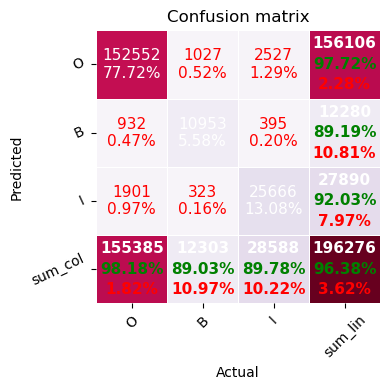

In [38]:
flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
true_labels_flatten=flatten(true_labels)
pred_labels_flatten=flatten(pred_labels)

print((classification_report(true_labels_flatten, pred_labels_flatten, target_names=['O', 'B', 'I'])))

#plot confusion matrix
c=confusion_matrix(true_labels_flatten,pred_labels_flatten)
df_c=pd.DataFrame(c,index=[i for i in ['O','B','I']],columns=[i for i in ['O','B','I']])
pp_matrix(df_c,figsize=(4,4),cmap='PuRd')

**1と2同一視**

              precision    recall  f1-score   support

           O       0.98      0.98      0.98    155385
         B+I       0.93      0.91      0.92     40891

    accuracy                           0.97    196276
   macro avg       0.95      0.95      0.95    196276
weighted avg       0.97      0.97      0.97    196276



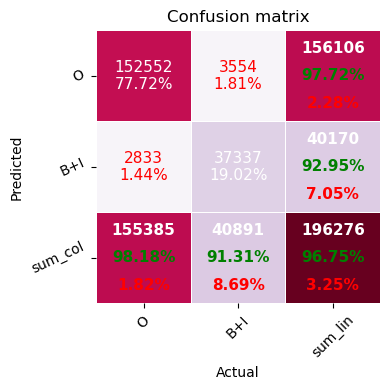

In [39]:
# If B and I are considered the same
true_labels_flatten_=[1 if true_labels_flatten[i]==2 else true_labels_flatten[i] for i in range(len(true_labels_flatten))]
pred_labels_flatten_=[1 if pred_labels_flatten[i]==2 else pred_labels_flatten[i] for i in range(len(pred_labels_flatten))]

print(classification_report(true_labels_flatten_, pred_labels_flatten_, target_names=['O', 'B+I']))

#plot confusion matrix
c_=confusion_matrix(true_labels_flatten_,pred_labels_flatten_)
df_c_=pd.DataFrame(c_,index=[i for i in ['O','B+I']],columns=[i for i in ['O','B+I']])
pp_matrix(df_c_,figsize=(4,4),cmap='PuRd')#    

**行の単位で**

In [3]:
with open('output_data/test_result_df_2.pkl', 'rb') as file:
    test_result_df=pickle.load(file)

In [22]:
test_result_df['result'] = test_result_df.apply(lambda x: True if len(x['result_pick']) >= len(x['pick_words']) else False, axis=1)
# 検出がある行を抽出
df_pick_true = test_result_df[test_result_df['pred_pick'].apply(lambda x: x != ['検出なし'])]

print('AE recall:', len(test_result_df[test_result_df['result']==True]) / len(test_result_df))
print('AE precision:', len(df_pick_true[df_pick_true['result']]) / len(df_pick_true))

AE recall: 0.9622513868218103
AE precision: 0.9647314161692893


In [29]:
# TN(pred=0,true=0)なし
#len(test_result_df)=7391　AEがある行(全部の行はAEがある)
#len(df_pick_true)=7372　AEが検出・予測を出した行
#len(df_pick_true[df_pick_true['result']])=7112　AEが検出・予測を出した行の中で正解を出した行

TP=len(df_pick_true[df_pick_true['result']]) 
FP=len(df_pick_true)-len(df_pick_true[df_pick_true['result']]) #7372-7112
FN=len(test_result_df)-len(df_pick_true[df_pick_true['result']]) #7391-7112
TN=0
print('TP:',TP)
print('FP:',FP)
print('FN:',FN)
print('TN:',TN)

TP: 7112
FP: 260
FN: 279
TN: 0


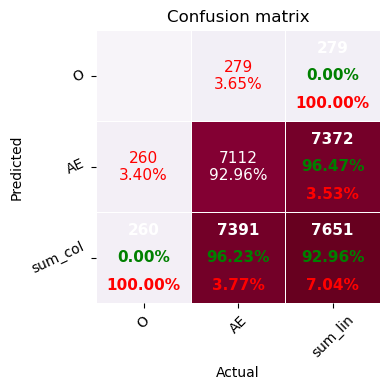

In [42]:
#plot confusion matrix
c__=np.array([[TN,   FP],
       [  FN,  TP]])
df_c=pd.DataFrame(c__,index=[i for i in ['O','AE']],columns=[i for i in ['O','AE']])
pp_matrix(df_c,figsize=(4,4),cmap='PuRd')